<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_experiment_5(leaky_relu).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Convolutional Autoencoder (CAE) — Experiment #5: Leaky ReLU Activation

This notebook investigates how different slopes of the Leaky ReLU activation function affect the training behavior and reconstruction performance of the CAE on the MNIST dataset.

---

## 📌 Objective

To explore whether adjusting the negative slope in the Leaky ReLU activation improves gradient flow and training efficiency without compromising reconstruction quality. The goal is to identify an optimal slope value for activation that balances performance and stability.

---

## 🔁 Experiment Workflow

1. Clone the project and configure dependencies  
2. Define CAE models using Leaky ReLU with varying slope values  
3. Train each model over 20 epochs using the same optimizer and scheduler  
4. Compare training dynamics and reconstruction quality with the baseline  
5. Record key observations and export results to GitHub

---

## 📊 Key Findings

- All Leaky ReLU variants converged smoothly without signs of instability  
- Slope = `0.1` showed the most stable and consistent performance  
- Slope = `0.01` behaved similarly to ReLU, while slope = `0.2` had slightly noisier convergence  
- Reconstruction quality across all variants was similar, with only subtle visual differences

---

## 1. 🔧 Setup

This section prepares the environment for running the experiment.

- Clone the GitHub repository  
- Import model classes and utility functions from `src/`  
- Import necessary libraries  
- Define constants

---

## 2. 🧠 Define Experiment Models

This section defines three CAE architectures that differ only in their Leaky ReLU slope parameter.

- `experiment_5_model_1`: `leaky_relu_slope = 0.01`  
- `experiment_5_model_2`: `leaky_relu_slope = 0.1`  
- `experiment_5_model_3`: `leaky_relu_slope = 0.2`

All other hyperparameters remain consistent with the baseline model, including:

- Filters: `[32, 32, 64]`  
- Latent dimension: `32`  
- Batch sizes: 32 (train) / 500 (validation)  
- Optimizer: Adam (`lr = 1e-3`)  
- Scheduler: `ReduceLROnPlateau`  
- Epochs: 20  

---

## 3. 🏋️‍♀️ Train Experiment Models

Each variant is trained using the `run_model_training()` function under identical conditions.

For each configuration:
- A model is instantiated with its specific `leaky_relu_slope`  
- Training uses the same dataloaders, optimizer, and scheduler  
- Training and validation losses are tracked  
- Final models and training histories are saved for comparison

This setup ensures a fair evaluation of the slope parameter's impact.



## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curves

All three Leaky ReLU variants successfully converged without signs of instability:

- The model with `slope = 0.01` performed very similarly to the ReLU baseline, showing steady but relatively sharp loss descent  
- The `slope = 0.1` variant produced the **smoothest convergence**, with both training and validation losses closely aligned throughout training  
- The model with `slope = 0.2` showed slightly noisier validation loss, possibly due to overly permissive negative activation flow

Despite minor differences, all models reached a stable plateau within the first 10 epochs, confirming that 20 epochs was sufficient.

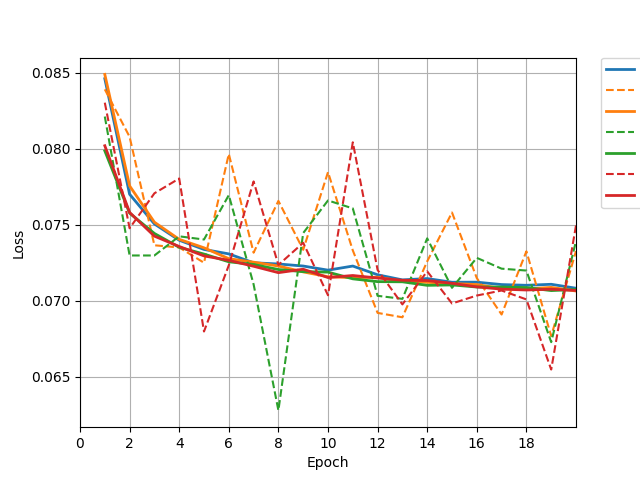

In [23]:
display(Image(filename="/content/CAE-MNIST/outputs/experiment_5_files/experiment_5_image_loss.png"))

### 4.2 🖼️ Reconstruction Comparison

Visual inspection of reconstructed digits reveals that all three models produced clean, faithful reconstructions:

- Differences between slope values are **nearly indistinguishable to the human eye**  
- The model with `slope = 0.1` yielded slightly crisper edges in some digits, but overall structure and quality were consistent across all variants  
- No distortions or artifacts were observed, indicating that activation slope does not critically impact reconstruction quality in this setting

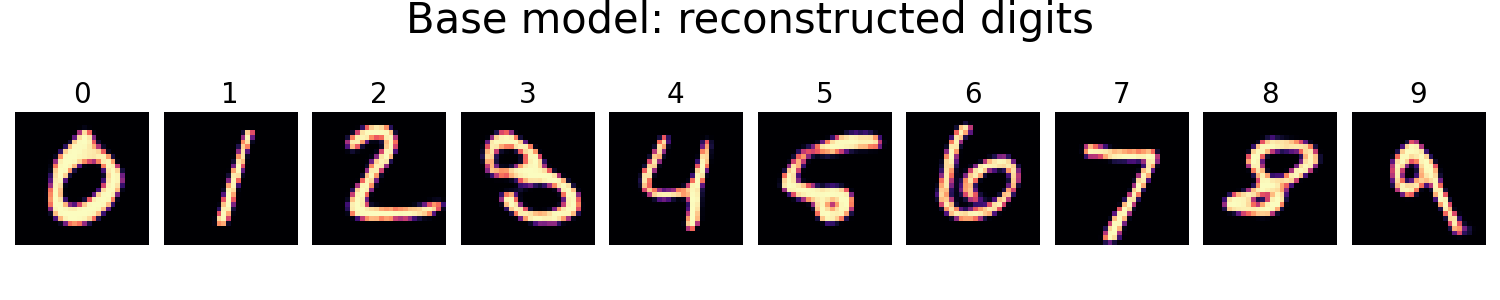

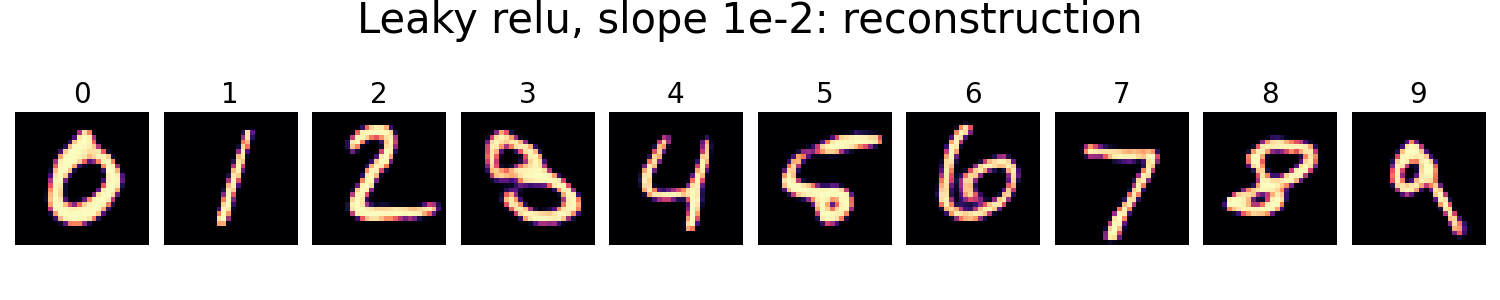

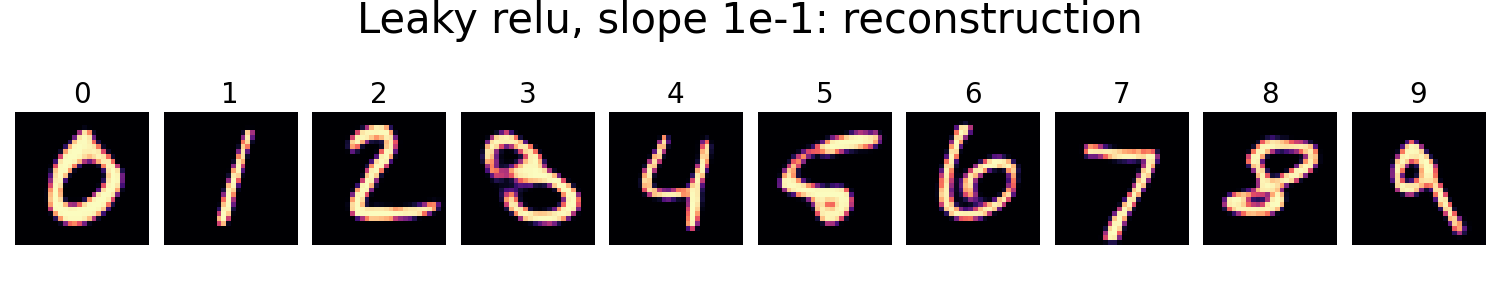

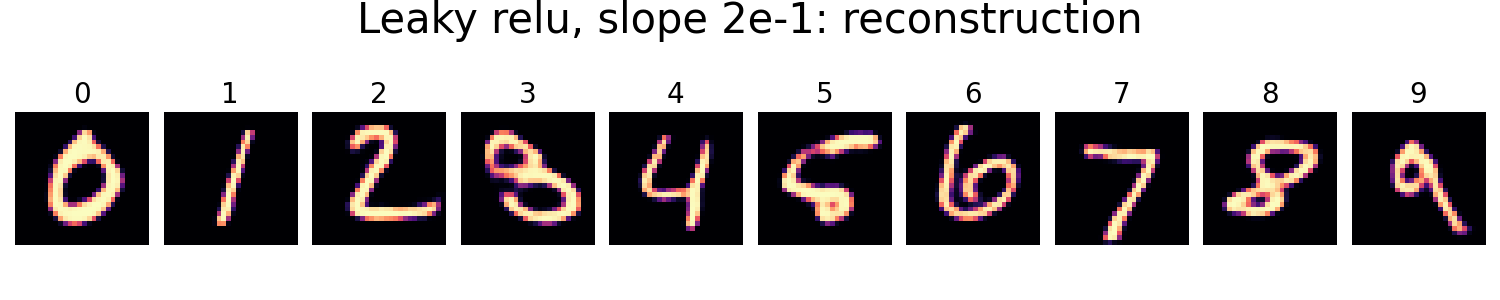

In [24]:
disply_reconstruction_images(5, 3)

## 5. ✅ Conclusion

This experiment demonstrates that using Leaky ReLU in place of standard ReLU has no meaningful impact on the reconstruction quality or training performance of a convolutional autoencoder for MNIST digits.

While minor differences in convergence smoothness were observed, the final loss values and visual results remained nearly identical across all slope configurations. As a result, the use of Leaky ReLU is not justified in this context.

To simplify the architecture and reduce unnecessary complexity, **standard ReLU remains the preferred choice** for this type of task.

---
---

# 🛠️ Notebook Workflow
The sections below contain the actual code used to define, train, and evaluate the variant CAE models for this experiment. This includes model setup, training logic, and result generation. These blocks serve as the working core of the notebook and support the summary presented above

## 1. 🔧 Setup

In [1]:
from getpass import getpass

# get repo url
token = getpass("Paste your GitHub token")
user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

# clone the repo
!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"
!git clone {repo_url}

# append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 641, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 641 (delta 102), reused 55 (delta 26), pack-reused 467 (from 1)
Receiving objects: 100% (641/641), 20.19 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (333/333), done.


In [2]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_digits_row, plot_experiment_reconstructions, plot_experiment_history, disply_reconstruction_images

# import exporting functions
from src.export import save_experiment_files, export_experiment_files

In [3]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

# Import utility to display images directly in notebook
from IPython.display import Image, display

In [4]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## 2. 🧠 Define Experiment Models



In [5]:
# Load base model description
base_model_files_path = '/content/CAE-MNIST/outputs/base_model_files'
with open(os.path.join(base_model_files_path, 'base_description.txt'), 'r') as f:
    base_description = f.read()

# print baseline model description
print(base_description)

Baseline model configuration:
- Architecture: n_channels = [32, 32, 64], latent_dim = 32
- Batch normalization: False
- Activation function: ReLU
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training: 20 epochs
- Train batch size: 32
- Validation batch size: 500


In [6]:
# define base parameters from the description
base_n_channels=[32, 32, 64]
base_latent_dim=32
base_train_batch_size=32
base_validation_batch_size=500
base_num_epoch=20

# initialize base dataloaders
base_train_dataloader = get_train_dataloader(batch_size=base_train_batch_size, data_dir='../data')
base_validation_dataloader = get_validation_dataloader(batch_size=base_validation_batch_size, data_dir='../data')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.69MB/s]


In [7]:
# define experiment 5 description: usage of leaky relu
experiment_5_description = """
Experiment 5: effect of activation function
Three alternative settings:
experiment_5_model_1: activation function = Leaky ReLU, leaky_relu_slope = 1e-2
experiment_5_model_2: activation function = Leaky ReLU, leaky_relu_slope = 1e-1
experiment_5_model_3: activation function = Leaky ReLU, leaky_relu_slope = 2e-1
Other parameters are the same as for the base line model
"""
print(experiment_5_description.strip())

# initialize experiment lists
experiment_5_losses = []
experiment_5_models = []

# define list of leky relu slopes
experiment_5_leaky_relu_slopes = [1e-2, 1e-1, 2e-1]

Experiment 5: effect of activation function
Three alternative settings:
experiment_5_model_1: activation function = Leaky ReLU, leaky_relu_slope = 1e-2
experiment_5_model_2: activation function = Leaky ReLU, leaky_relu_slope = 1e-1
experiment_5_model_3: activation function = Leaky ReLU, leaky_relu_slope = 2e-1
Other parameters are the same as for the base line model


## 3. 🏋️‍♀️ Train Experiment Models

In [8]:
# run experiments with different leaky relu slopes
for slope_i in experiment_5_leaky_relu_slopes:
  # create model with Leaky ReLU activation and slope parameter
  model = AutoEncoder(
      n_channels=base_n_channels,
      latent_dim=base_latent_dim,
      activation_func='leaky_relu',
      leaky_relu_slope=slope_i
  ).to(device)

  # define optimizer and scheduler
  base_optimizer = optim.Adam(model.parameters(), lr=1e-3)
  base_scheduler = ReduceLROnPlateau(
      base_optimizer,
      mode='min',
      threshold=1e-3,
      patience=3,
      factor=0.5
  )

  # train model
  model, loss_history = run_model_training(
      model=model,
      train_dataloader=base_train_dataloader,
      validation_dataloader=base_validation_dataloader,
      optimizer=base_optimizer,
      scheduler=base_scheduler,
      num_epoch=base_num_epoch,
      device=device
  )

  # record results
  experiment_5_losses.append(loss_history)
  experiment_5_models.append(model)


TRAINING IS STARTED:
Epoch  1 | Train Loss: 0.0839 | Validation Loss: 0.0849
Epoch  2 | Train Loss: 0.0808 | Validation Loss: 0.0776
Epoch  3 | Train Loss: 0.0737 | Validation Loss: 0.0752
Epoch  4 | Train Loss: 0.0735 | Validation Loss: 0.0740
Epoch  5 | Train Loss: 0.0725 | Validation Loss: 0.0735
Epoch  6 | Train Loss: 0.0797 | Validation Loss: 0.0728
Epoch  7 | Train Loss: 0.0732 | Validation Loss: 0.0725
Epoch  8 | Train Loss: 0.0766 | Validation Loss: 0.0723
Epoch  9 | Train Loss: 0.0734 | Validation Loss: 0.0719
Epoch 10 | Train Loss: 0.0785 | Validation Loss: 0.0716
Epoch 11 | Train Loss: 0.0733 | Validation Loss: 0.0715
Epoch 12 | Train Loss: 0.0692 | Validation Loss: 0.0716
Epoch 13 | Train Loss: 0.0689 | Validation Loss: 0.0713
Epoch 14 | Train Loss: 0.0726 | Validation Loss: 0.0712
Epoch 15 | Train Loss: 0.0758 | Validation Loss: 0.0711
Epoch 16 | Train Loss: 0.0715 | Validation Loss: 0.0711
Epoch 17 | Train Loss: 0.0691 | Validation Loss: 0.0708
Epoch 18 | Train Loss: 0.0

## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curve Analysis

In [9]:
# import base loss
base_loss = torch.load('/content/CAE-MNIST/outputs/base_model_files/base_loss.pth')

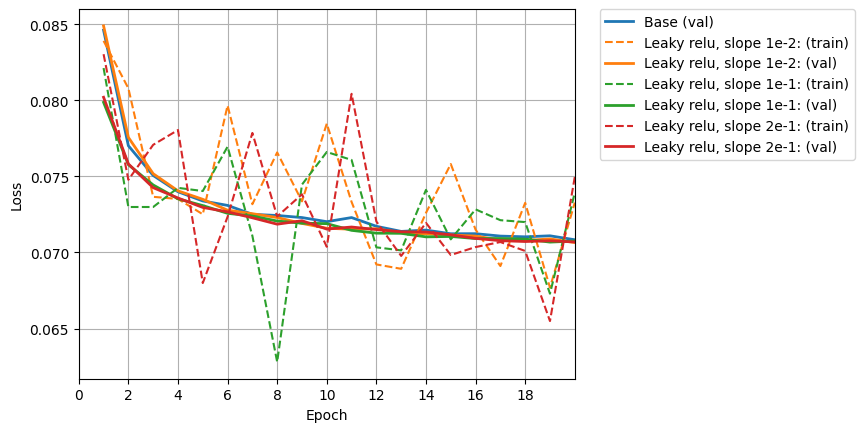

In [12]:
# plot baseeline validation loss
plot_experiment_history([base_loss], label_list=['Base'])

# plot training and validation losses for experiment 5 models
plot_experiment_history(
    loss_list=experiment_5_losses,
    label_list=[
        'Leaky relu, slope 1e-2:',
        'Leaky relu, slope 1e-1:',
        'Leaky relu, slope 2e-1:'
    ],
    color=plt.get_cmap('tab10').colors[1:],
    to_plot_train=True
)

# format plot
plt.xlim(1, base_num_epoch)
plt.xticks(range(0, base_num_epoch, 2))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()

# save plot
plt.savefig("CAE-MNIST/outputs/experiment_5_files/experiment_5_image_loss.png")
plt.show()

In [13]:
# manually add and push experiment 5 loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/experiment_5_files/experiment_5_image_loss.png
!git -C /content/CAE-MNIST commit -m "Add experiment 5 loss history curve"
!git -C /content/CAE-MNIST push origin main

[main f34ee3f] Add experiment 5 loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/experiment_5_files/experiment_5_image_loss.png
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 62.10 KiB | 15.52 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   8e74f0f..f34ee3f  main -> main


### 4.2 📷 Reconstruction Quality Analysis

In [15]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(base_validation_dataloader)

# get reconstructed images from experiment 5
experiment_5_reconstructions = get_experiment_reconstructions(experiment_5_models, sample_images, device)

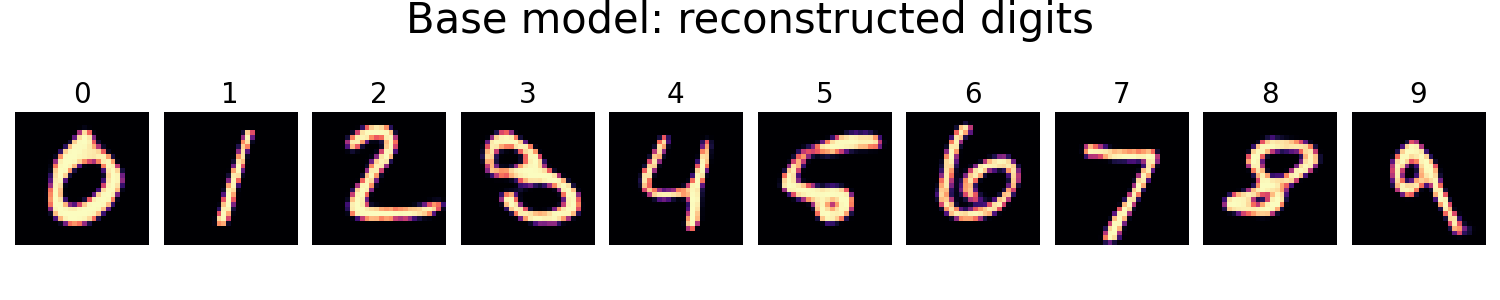

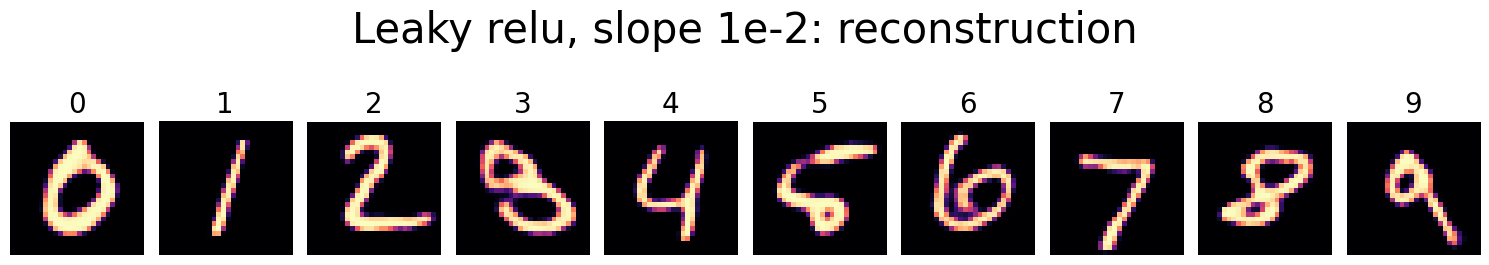

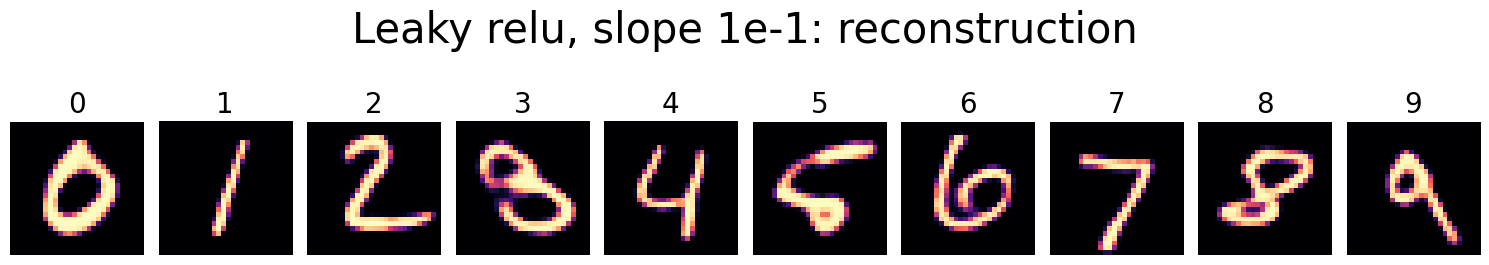

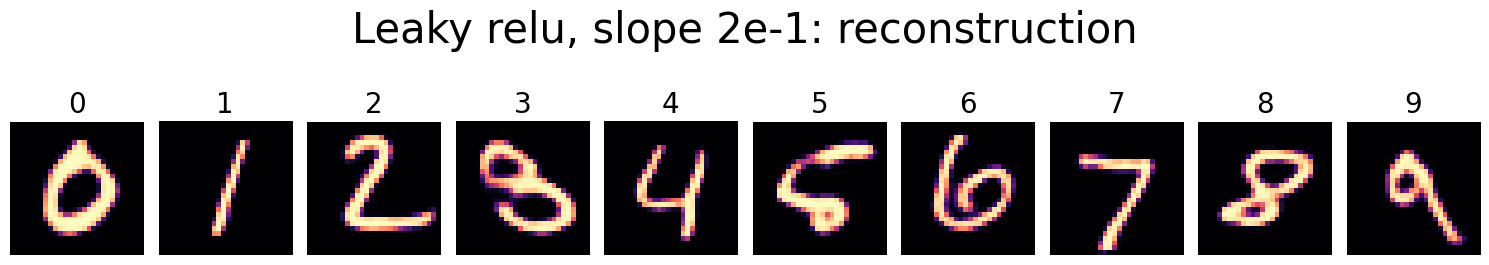

In [16]:
# display reconsructions from baseline model
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
print('\n')

# display reconstructions from experiment
experiment_5_reconstruction_figures = plot_experiment_reconstructions(
    experiment_5_reconstructions,
    sample_labels,
    title_list=[
        'Leaky relu, slope 1e-2:',
        'Leaky relu, slope 1e-1:',
        'Leaky relu, slope 2e-1:'
    ]
    )

for idx, fig in enumerate(experiment_5_reconstruction_figures):
  fig.savefig(f"CAE-MNIST/outputs/experiment_5_files/experiment_5_image_reconstruction_{idx+1}.png")

In [17]:
#manually add and push experiment 5 reconstruction images to Git repository
for idx, _ in enumerate(experiment_5_reconstruction_figures):
  !git -C /content/CAE-MNIST add outputs/experiment_5_files/experiment_5_image_reconstruction_{idx+1}.png

!git -C /content/CAE-MNIST commit -m "Add experiment 5 reconstructed digits"
!git -C /content/CAE-MNIST push origin main

[main 809c296] Add experiment 5 reconstructed digits
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/experiment_5_files/experiment_5_image_reconstruction_1.png
 create mode 100644 outputs/experiment_5_files/experiment_5_image_reconstruction_2.png
 create mode 100644 outputs/experiment_5_files/experiment_5_image_reconstruction_3.png
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 80.59 KiB | 20.15 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   f34ee3f..809c296  main -> main


## 6. 📂 Export Experiment 5 Files

In [18]:
# save all experiment 5 outputs (models, losses, reconstructions, description)
save_experiment_files(
    experiment_name="experiment_5",
    models=experiment_5_models,
    losses=experiment_5_losses,
    reconstructions=experiment_5_reconstructions,
    description_text=experiment_5_description
)

✅ Saved experiment_5 files to: /content/CAE_experiment_5_local


In [19]:
# export experiment 5 files to Git
export_experiment_files(
    experiment_name="experiment_5",
    model_count=len(experiment_5_models)
)

✅ Exported experiment_5 files to: outputs/experiment_5_files/


# Import Experiment 5 Files

In [20]:
# Paths
outputs_path = '/content/CAE-MNIST/outputs/experiment_5_files'

# Storage lists
experiment_5_models = []
experiment_5_losses = []
experiment_5_reconstructions = []

# Initialize model
model = AutoEncoder(
    n_channels=base_n_channels,
    latent_dim=base_latent_dim,
    activation_func=True
).to(device)

# Load model weights
model_file = 'experiment_5_model_1.pth'
model_path = os.path.join(outputs_path, model_file)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
experiment_5_models.append(model)

# Load loss history
loss_file = 'experiment_5_loss_1.pth'
loss_path = os.path.join(outputs_path, loss_file)
loss_history = torch.load(loss_path)
experiment_5_losses.append(loss_history)

# Load reconstructed images
reconstructed_file = 'experiment_5_reconstruction_1.pth'
reconstructed_path = os.path.join(outputs_path, reconstructed_file)
reconstructed_images = torch.load(reconstructed_path)
experiment_5_reconstructions.append(reconstructed_images)

# Load experiment description
with open(os.path.join(outputs_path, 'experiment_5_description.txt'), 'r') as f:
    experiment_5_description = f.read()

print("✅ All experiment 5 models, losses, reconstructed images and description loaded.")

✅ All experiment 5 models, losses, reconstructed images and description loaded.


## Re-Clone Git Repository

In [ ]:
!rm -rf /content/CAE-MNIST
!git clone {repo_url}